Todo: 
 - How the urban effect can be seen through climatology 
 - Impact of TEB at particular points such as station in and outside city centre, compute diffs from station data w/wo TEB
 - Do that for multiple stations and observe the effects
 - seasonal averages
 - Verify against station data
 - Investigate urban fraction field
 - Max and mim fields
 - 

Over the next two weeks
   Spatial seasonally averaged maps of T, TMAX, and TMIN
   Check out figure 4 and 16 of the report
   
Definition of the UHI

Urban fraction vs temperature graph, dots for station 
/runoff/winger/Output/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU/Samples/StLaurent_1km_SL2.5_ERA5_advHU_step0
Usually, there should be a directory ending on *_step0 in the Samples directory. The field 2V, level 21 of the pm-file in that directory contains the urban fraction. You can use xrec to observe it as long as you've ssh'd using -YC
 


# <b> Analysis Scripts for Montréal Urban Heat Waves </b>

The purpose of this file is to keep a record of scripts used to analyse CRCM6/GEM5 model output for the analysis of the urban heat island effect on historical heat waves. It includes the setup, analysis of observation and model output, and the code for plotting map data for the project.

# Table of Contents
1. <a href="#setup">Setup</a>
    - <a href="11-imports">1.1 Imports and Libraries</a>
    - <a href="#12-functions">1.2 Functions</a>
    - <a href="#13-datasets">1.2 Datasets</a>
2. <a href="#station-observations-and-model-output-data-visualisation">Station Observations and Model Output Data Visualisation</a>
    - <a href="#21-station-observations">2.1 Station Observations</a>
    - <a href="#22-comparison-of-stations-to-simulation-output">2.2 Comparison of Stations to Simulation Output</a>
    - <a href="#23-formatting-model-output">2.3 Formatting Model Output</a>

---

# 1. Setup
Common tools used throughout various scripts in the collection, analysis, and display of data throughout the project.

## <a id="11-imports"></a> 1.1 Imports

In [1]:
# !jupyter nbextension enable --py widgetsnbextension
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import ipywidgets as widgets
from IPython.display import display
from ipywidgets import interact

## <a id="12-functions"></a> 1.2 Functions
Custom statistical and numerical techniques usage and reference. 

In [2]:
#For projections of all map data used here
rotated_pole = ccrs.RotatedPole(pole_longitude=np.float32(106.425), pole_latitude=np.float32(44.5))

In [3]:
class Station:
    """
    A class holding key information about an instance of a particular weather station.

    Attributes
    ----------
    lattitude, longitude : float
        The real-life position of the weather station.
    rotated_lat, rotated_lon : float
        The rotated projection of the station's coordinates.

    Functions
    ----------
    get_time_series : array_like
        The time series of the field at the station's location
    """
    
    name = ""
    lattitude = 0
    longitude = 0
    rotated_lat = 0
    rotated_lon = 0
    
    
    def __init__(self,lat,lon):
        self.lattitude = lat
        self.longitude = lon
        self.rotated_lon, self.rotated_lat = rotated_pole.transform_point(real_lon, real_lat, ccrs.PlateCarree())
        
    
    def get_time_series(self,field):
        """
        Retrieves the time series of the field at the latitude and longitude of the station. 
        
        Parameters
        ----------
        field : array_like
            Minimum, maximum, or average temperature, or humidity, spatial data in time.
        
        Returns
        ----------
        array_like
            Time series of the field at the station's location
        
        """
        
        return field.interp(rlon=self.rotated_lon, rlat=self.rotated_lat) 
    
        

In [4]:
def seasonalMeans(dataset):
    """
    Calculates time average of a field for each season.

    Parameters
    ----------
    dataset : xarray.DataSet()
        The time series of the temperature of humidity field.

    Returns
    ----------
    xarray.DataSet()
        The seasonal means of the field.
    """

    return dataset.groupby('time.season').mean('time')

## <a id="13-datasets"></a> 1.3 Datasets

In [ ]:
paths_ERA5_noTEB = glob('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU/*tas.nc')
tas_ERA5_noTEB = xr.open_mfdataset(paths_ERA5_noTEB)
tas_ERA5_noTEB

In [ ]:
paths_ERA5_TEB = glob('/runoff/gulley/St_Laurent/StLaurent_1km_SL2.5_ERA5_advHU_TEB/*tas.nc')
tas_ERA5_TEB = xr.open_mfdataset(paths_ERA5_TEB)
tas_ERA5_TEB

In [ ]:
rlat = tas_ERA5_noTEB['rlat'].values
rlon = tas_ERA5_noTEB['rlon'].values

In [ ]:
#Dictionary to hold each field for easier access in later subroutines
fields = {
    "tas_ERA5_TEB" : tas_ERA5_TEB,
    "tas_ERA5_noTEB" : tas_ERA5_noTEB
}

units = {
    "tas_ERA5_TEB" : "K",
    "tas_ERA5_noTEB" : "K"
}

variables = {
    "tas_ERA5_TEB" : "tas",
    "tas_ERA5_noTEB" : "tas"
}

Importing the urban fraction static field

# 2. Station Observations and Model Output Data Visualisation
<!-- In this section:
- <a href="#21-station-observations">2.1 Station Observations</a>
- <a href="#22-comparison-of-stations-to-simulation-output">2.2 Comparison of Stations to Simulation Output</a>
- <a href="#23-formatting-model-output">2.3 Formatting Model Output</a> -->

## <a id="21-station-observations"></a>2.1 Station Observations
Multiyear monthly means to do mean annual cycles, annual means and seasonal means of temperature using station observations

## <a id="22-comparison-of-stations-to-simulation-output"></a>2.2 Comparison of Stations to Simulation Output
Select the closest grid cells of the simulations at 1km with and without TEB from few weather stations and compute multiyear monthly means to do mean annual cycles, annual means and seasonal means of temperature.

### McTavish

Latitude:
45°30'17.070" N
Longitude:
73°34'45.000" W
Elevation:
72.80 m
Climate ID:
7024745
WMO ID:
71612
TC ID:
WTA


### Mirabel

Latitude:
45°40'00.000" N
Longitude:
74°02'00.000" W
Elevation:
82.60 m
Climate ID:
7035290
WMO ID:
TC ID:
YMX


### La Prairie

Latitude:
45°23'00.000" N
Longitude:
73°26'00.000" W
Elevation:
30.00 m
Climate ID:
7024100
WMO ID:
TC ID:

### Saint-Hubert 

Latitude:
45°31'00.000" N
Longitude:
73°25'00.000" W
Elevation:
27.40 m
Climate ID:
7027322
WMO ID:
71371
TC ID:
YHU

### Mascouche

Latitude:
45°45'00.000" N
Longitude:
73°36'00.000" W
Elevation:
15.20 m
Climate ID:
7014629
WMO ID:
TC ID:


In [23]:
mctavish = Station(45.504742,-73.579167)
mirabel = Station(45.666667,-74.033333)
la_prairie = Station(45.383333,-74.433333)
saint_hubert = Station(45.516667,-74.416667)
mascouche = Station(45.75,-74.6)

stations = {
    "McTavish" : mctavish,
    "Mirabel" : mirabel,
    "La Prairie" : la_prairie,
    "Saint-Hubert" : saint_hubert,
    "Mascouche" : mascouche
}

In [ ]:
#Plotting the time series of each station for the TEB and noTEB simulation output

#The field to plot (such as tas)
for station_name in stations:
    field_name_noTEB = "tas_ERA5_noTEB" #change later
    field_name_TEB = "tas_ERA5_TEB"     #change later
    
    field_TEB = fields[field_name_TEB]
    field_noTEB = fields[field_name_noTEB]
    variable_name = variables[field_name_noTEB] #Should be comparing only the same fields
    
    station = stations[station_name]
    times =  field_TEB['time'].squeeze()
    series_TEB = station.get_time_series(field_TEB)[variable_name]
    series_noTEB = station.get_time_series(field_noTEB)[variable_name]
    
    fig, axes = plt.subplots(figsize=(12, 6))
    plt.plot(times,series_TEB,label = field_name_TEB)
    plt.plot(times, series_noTEB, label = field_name_noTEB)
    plt.xlabel('Time')
    plt.ylabel(f"variable_name ({units[field_name_noTEB]})")
    plt.legend()
    plt.title(f'{station_name}')
    plt.grid(True)
    plt.show()
    

## <a id="23-formatting-model-output"></a>2.3 Formatting Model Output
Maps with python of seasonal means, and compute and plot differences between two simulations (with and without TEB)
### 2.3.1 Raw Instantaneous Geospatial Output
Below visualises the output of the simulation, the field evolution in time over the entire domain.

In [97]:
ds =  #contains the dataset to be displayed from the code for the interactive widget that follows

In [ ]:
#For plotting and displaying model output contained in ds
def plot_temperature(time_index):
    """
    Plots the temperature field in the Montréal region of interest at a given time index of the ds xarray.Dataset()
    
    Parameters
    -----------
    time_index : int
        Index corresponding to some date within the dataset
    """
#     min_temp = 223.15
#     max_temp = 323.15
    min_temp = -10
    max_temp = 10
    
    plt.figure(figsize=(15, 9))
    data = ds['tas'].isel(time=time_index).squeeze()
    ax = plt.subplot(1, 1, 1, projection=rotated_pole)
    ax.add_feature(cfeature.BORDERS,edgecolor='grey')
    ax.add_feature(cfeature.LAKES, edgecolor='grey', facecolor='none')
    ax.add_feature(cfeature.RIVERS, edgecolor='grey', facecolor='none')
    ax.add_feature(cfeature.COASTLINE,edgecolor='grey')
    mesh = ax.pcolormesh(ds['rlon'], ds['rlat'], data, transform=rotated_pole, cmap='coolwarm',vmin=min_temp,vmax=max_temp)
    plt.colorbar(mesh, orientation='vertical', label='Temperature (K)')
    title = ds.indexes['time'][time_index]
    plt.title(f'{title}')
    plt.show()

# Play widget
play = widgets.Play(
    value=0,
    min=0,
    max=ds.sizes['time'] - 1,
    step=10,
    interval=100,  # Milliseconds between updates
    description="",
    disabled=False
)

# Slider linked to the play widget
slider = widgets.IntSlider(
    value=0,
    min=0,
    max=ds.sizes['time'] - 1,
    step=10,
    description = "",
    layout=widgets.Layout(width='1000px')
)

# Link the play widget and the slider
widgets.jslink((play, 'value'), (slider, 'value'))

#Displaying the map with slider and play widget
display(play)
time_slider = interact(
    plot_temperature,
    time_index=slider,
)



In [ ]:
seasonal_means = seasonalMeans(ds)

#December January Feb, March April May, June July August, September October November
seasons = ['DJF', 'MAM', 'JJA', 'SON']  
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

for ax, season in zip(axes.flat, seasons):
    data = seasonal_means['tas'].sel(season=season)
    mesh = ax.pcolormesh(seasonal_means['rlon'], seasonal_means['rlat'], data, transform=rotated_pole, cmap='coolwarm',vmin=223.15,vmax=323.15)
    plt.colorbar(mesh, orientation='vertical', label='Temperature (K)')
    ax.set_title(f'{season} Average Temperature')

plt.tight_layout()
plt.show()

### 2.3.2 Raw Difference Field
The difference field between the TEB and non-TEB simulation is recorded below. It can be displayed by setting diff to the ds variable in 2.3.1 for its raw evolution in time. The spatially averaged result of this is created below.

In [ ]:
diff = (tas_ERA5_TEB['tas'] - tas_ERA5_noTEB['tas']).expand_dims(lev=[1.5]).to_dataset(name='tas')
diff

In [8]:
spatial_avg_diffs = diff.mean(dim=['rlat', 'rlon'])
spatial_avg_diff_temps = spatial_avg_diffs['tas'].squeeze()

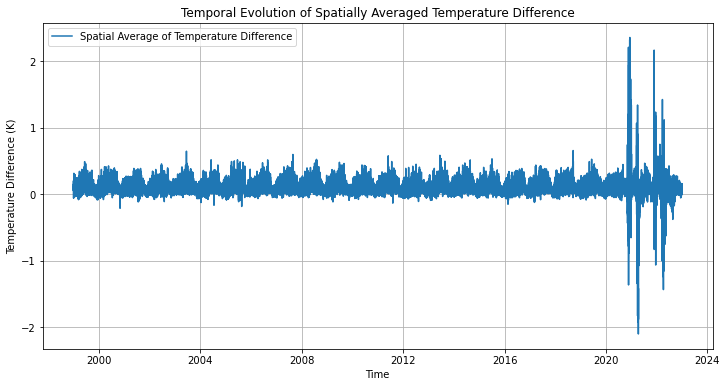

In [69]:
plt.figure(figsize=(12, 6))
plt.plot(spatial_avg_diffs['time'], spatial_avg_diff_temps, label='Spatial Average of Temperature Difference')
plt.xlabel('Time')
plt.ylabel('Temperature Difference (K)')
plt.title('Temporal Evolution of Spatially Averaged Temperature Difference')
plt.legend()
plt.grid(True)
plt.show()

A fourier analysis of the differe in time could offer some insight into the scales in which the temperature variations collect on.

In [ ]:
fft_spatial_avg_diff_temps = np.fft.fft(spatial_avg_diff_temps)
fft_freqs_spatial_avg_diff_temps = np.fft.fftfreq(spatial_avg_diff_temps.size, d=1/24)

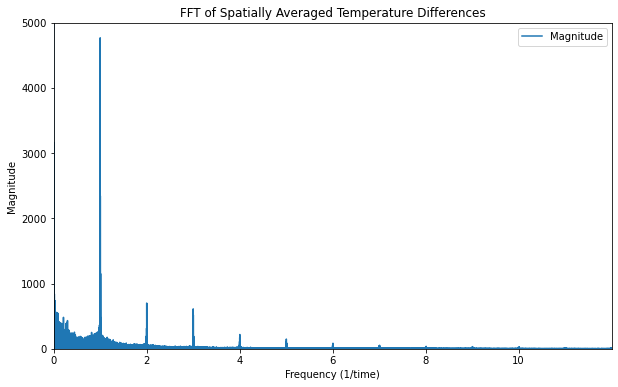

In [92]:
fft_result = fft_spatial_avg_diff_temps
fft_freqs = fft_freqs_spatial_avg_diff_temps

plt.figure(figsize=(10, 6))
plt.plot(fft_freqs, np.abs(fft_result), label='Magnitude')
plt.xlabel('Frequency (1/time)')
plt.ylabel('Magnitude')
plt.title('FFT of Spatially Averaged Temperature Differences')
plt.xlim(0, max(fft_freqs))
# plt.xlim(0.99,1.01)
plt.ylim(0,5000)
plt.legend()
plt.show()

In [ ]:
time_avg_diffs = diff.mean(dim='time')
time_avg_diffs

In [ ]:
data = time_avg_diffs['tas'].squeeze()
plt.figure(figsize=(10, 6))
mesh = plt.pcolormesh(rlon, rlat, data, cmap='coolwarm', shading='auto', vmin = -2.5, vmax = 2.5)
mesh = ax.pcolormesh(ds['rlon'], ds['rlat'], data, transform=rotated_pole, cmap='coolwarm',vmin=min_temp,vmax=max_temp)
plt.colorbar(mesh,label='Average Temperature Difference (K)')
plt.title('Time-Averaged Temperature Differences')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

The mean may not offer as much insight as would spatial variance of the diff field. 

In [11]:
time_avg_diff_stdev = diff.std(dim='time')